<a href="https://colab.research.google.com/github/alexsalman/CSE247/blob/main/2D_CNN%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow import keras

from PIL import Image

%matplotlib inline
 
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
drive.mount('/content/gdrive/', force_remount=True)
gdrive_path = '/content/gdrive' + '/My Drive/247/'
os.chdir(gdrive_path)
print(os.getcwd())

Mounted at /content/gdrive/
/content/gdrive/My Drive/247


In [ ]:
IMAGE_HEIGHT, IMAGE_WIDTH = 150, 150
SEQUENCE_LENGTH = 16
DATASET_DIR = gdrive_path + 'Cropped_videos'
print(DATASET_DIR)
CLASSES_LIST = ['hemostasis', 'inflammatory', 'proliferative', 'maturation']

/content/gdrive/My Drive/247/Cropped_videos


In [ ]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

In [ ]:
def load_video(path, max_frames = 16, resize=(150, 150)):
    video_reader = cv2.VideoCapture(path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    # print('video_frames_count before padding', video_frames_count)
    frames = []
    try:
        while True:
            ret, frame = video_reader.read()
            if not ret:
                  break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            black_frame = frame
            frames.append(frame)
    finally:
        video_reader.release()
    return np.array(frames) / 255.0


In [ ]:
def create_dataset(state):
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''
 
    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            # print(video_file_path)
            if state == 2:
                mouse_number = int(video_file_path.split(' ')[2].split('_')[1].split('-')[1])
                if mouse_number == 4:

                    frames = load_video(video_file_path)

                    if len(frames) == SEQUENCE_LENGTH:
                        features.append(frames)
                        labels.append(class_index)
                        video_files_paths.append(video_file_path)

            else:
                mouse_number = int(video_file_path.split(' ')[2].split('_')[1].split('-')[1])
                # print(video_file_path)
                # print(mouse_number)
                if mouse_number != 4:

                    frames = load_video(video_file_path)

                    if len(frames) == SEQUENCE_LENGTH:
                        features.append(frames)
                        labels.append(class_index)
                        video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    # print(features)
    labels = np.array(labels)

    # targets_train = to_categorical(targets_train).astype(np.integer)
    # targets_test = to_categorical(targets_test).astype(np.integer)
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [ ]:
# whole random
# features, labels, video_files_paths = create_dataset()

# 6 mice / 2 mice (aged and young) 75/25
features_train, labels_train, video_files_paths_train = create_dataset(1)
features_test, labels_test, video_files_paths_test = create_dataset(2)

Extracting Data of Class: hemostasis
Extracting Data of Class: inflammatory
Extracting Data of Class: proliferative
Extracting Data of Class: maturation
Extracting Data of Class: hemostasis
Extracting Data of Class: inflammatory
Extracting Data of Class: proliferative
Extracting Data of Class: maturation


In [ ]:
# whole random
# one_hot_encoded_labels = to_categorical(labels)

# 6 mice / 2 mice (aged and young) 75/25
one_hot_encoded_labels_train = to_categorical(labels_train)
one_hot_encoded_labels_test = to_categorical(labels_test)

In [ ]:
print(len(one_hot_encoded_labels_train))
print(len(one_hot_encoded_labels_test))

1616
544


In [ ]:
# whole random
# features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)

# 6 mice / 2 mice (aged and young) 75/25
features_train = features_train
features_test = features_test
labels_train = one_hot_encoded_labels_train
labels_test = one_hot_encoded_labels_test

In [ ]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

In [ ]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()
 
# Display the success message. 
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 16, 148, 148, 4)   1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 16, 74, 74, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 16, 74, 74, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 16, 72, 72, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 16, 36, 36, 8)    0         
 3D)                                                             
                                                        

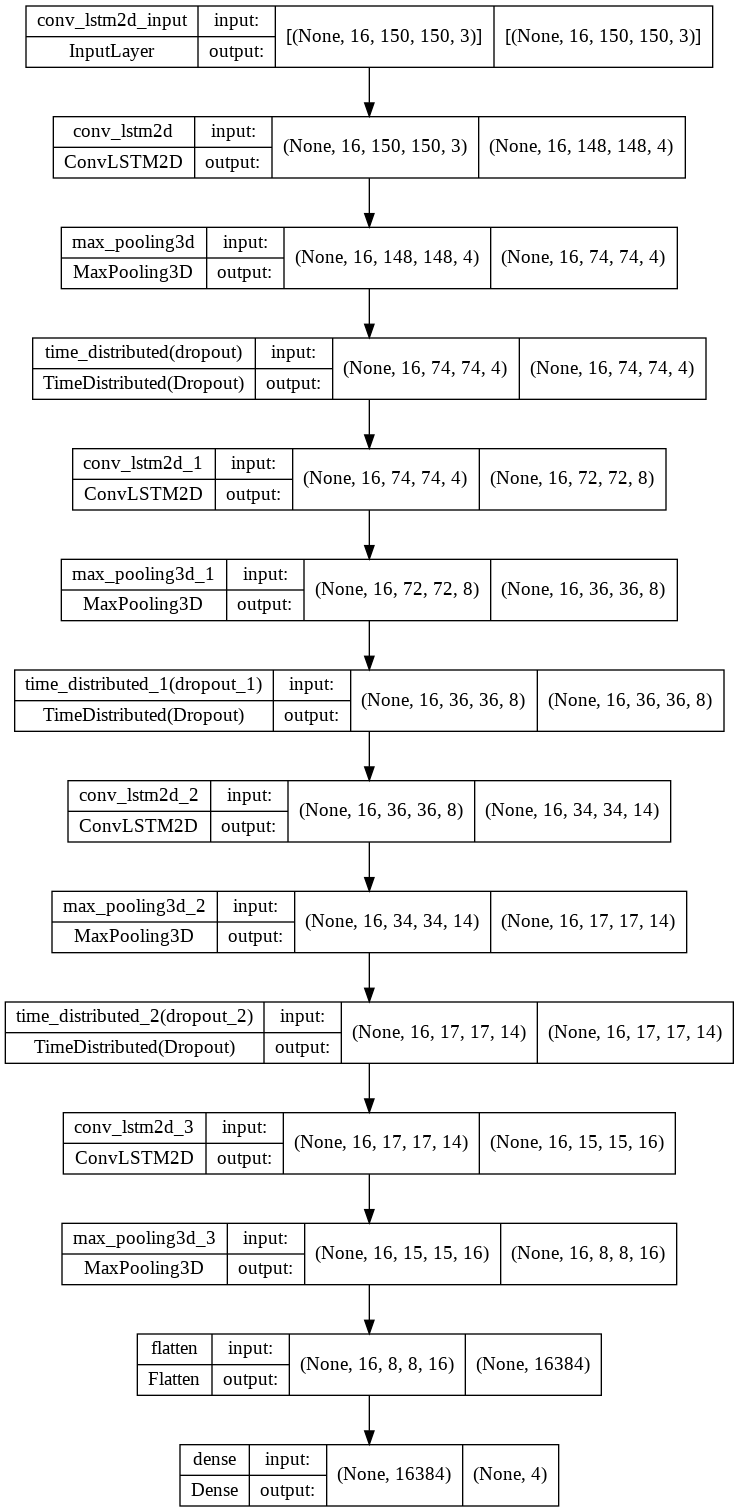

In [ ]:
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
323/323 [==============================] - 97s 274ms/step - loss: 0.9407 - accuracy: 0.5813 - val_loss: 1.1758 - val_accuracy: 0.0833
Epoch 2/50
323/323 [==============================] - 86s 267ms/step - loss: 0.7740 - accuracy: 0.6138 - val_loss: 0.9047 - val_accuracy: 0.4043
Epoch 3/50
323/323 [==============================] - 86s 267ms/step - loss: 0.6540 - accuracy: 0.6958 - val_loss: 0.6163 - val_accuracy: 0.6389
Epoch 4/50
323/323 [==============================] - 86s 267ms/step - loss: 0.5479 - accuracy: 0.7678 - val_loss: 1.6508 - val_accuracy: 0.3951
Epoch 5/50
323/323 [==============================] - 86s 265ms/step - loss: 0.4711 - accuracy: 0.8111 - val_loss: 1.8978 - val_accuracy: 0.4568
Epoch 6/50
323/323 [==============================] - 86s 265ms/step - loss: 0.4213 - accuracy: 0.8297 - val_loss: 2.8070 - val_accuracy: 0.3395
Epoch 7/50
323/323 [==============================] - 86s 266ms/step - loss: 0.4049 - accuracy: 0.8243 - val_loss: 2.9100 - val_ac

In [ ]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

17/17 [==============================] - 5s 220ms/step - loss: 0.7456 - accuracy: 0.6618


In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
 
# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
 
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
 
# Save your Model.
convlstm_model.save(model_file_name)

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

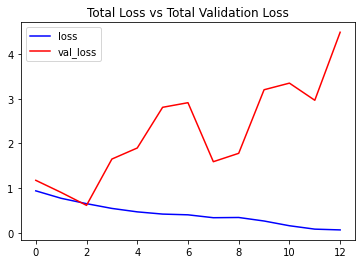

In [ ]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

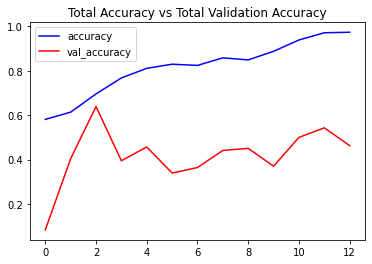

In [ ]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 